In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

In [2]:
# Parameters
nx = 300  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01  # Time step
a = 0.8  # Advection speed
T = 5.0  # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt))

CFL = a * dt / dx
print(f"CFL Number: {CFL}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

CFL Number: 0.47840000000000005
Epoch 0, Loss: 0.07918564230203629, PDE Loss: 0.001920415903441608, IC Loss: 0.05697515979409218, Boundary Loss: 0.016449233517050743
Epoch 1000, Loss: 0.0009531282121315598, PDE Loss: 0.00020116465748287737, IC Loss: 8.185773913282901e-05, Boundary Loss: 0.00026777651510201395
Epoch 2000, Loss: 0.0011711320839822292, PDE Loss: 0.0003445842594373971, IC Loss: 6.37495904811658e-05, Boundary Loss: 7.362966425716877e-05
Epoch 3000, Loss: 0.001735521829687059, PDE Loss: 0.0002811117155943066, IC Loss: 0.0007413621060550213, Boundary Loss: 0.00015082457684911788
Epoch 4000, Loss: 0.0007671131170354784, PDE Loss: 0.00020460730593185872, IC Loss: 6.870942161185667e-05, Boundary Loss: 8.45817630761303e-05
Epoch 5000, Loss: 0.000656735384836793, PDE Loss: 0.0001336118730250746, IC Loss: 0.00011871565220644698, Boundary Loss: 0.000137184135382995
Epoch 6000, Loss: 6.86142229824327e-05, PDE Loss: 1.6084994058473967e-05, IC Loss: 1.0613941412884742e-05, Boundary Los

ts
Upwind MSE: 0.03380765397010394
Upwind Norm: 3.184697189848853
LW MSE: 0.04917273765424652
LW Norm: 3.8408099791937063
NN MSE: 1.1993850178813733e-05
NN Norm: 0.0599846234767221


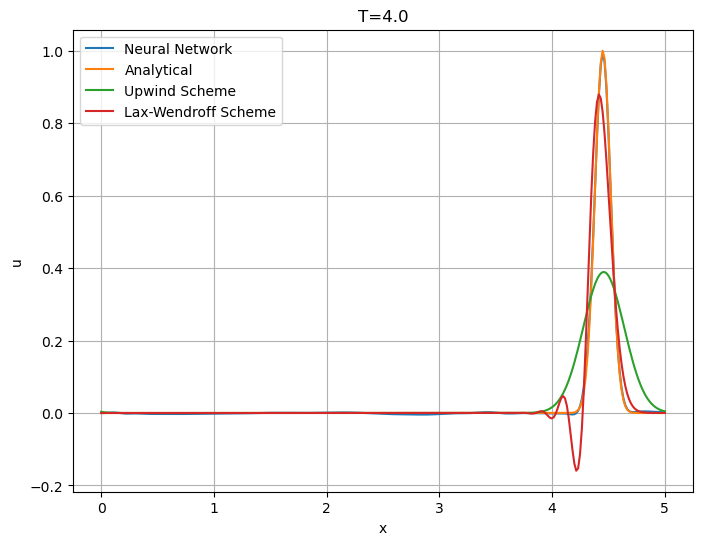

In [ ]:
# Plot the results
plt.figure(figsize=(8, 6))

# Time Step
time = 4.0

##############################################
# NN Solution
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot NN
t_test = torch.full_like(x_test,time) # Creates a vector with the same shape as x_test with a constant value equal to n
with torch.no_grad(): 
    u_nn = model(x_test, t_test).detach().numpy().flatten()  # Detach tensor before converting to NumPy
plt.plot(x, u_nn, label="Neural Network")

################################################
# Analytical Solution

x_shifted = (x - a * time) % L  # Apply periodic boundary condition
u_analytical = np.exp(-((x_shifted - L/4) / 0.1) ** 2)
plt.plot(x, u_analytical, label="Analytical")

##############################################
# Upwind Scheme
# Initial condition: Gaussian pulse
u = np.exp(-((x - L/4) / 0.1) ** 2)

u_new = np.zeros_like(u)

for n in range(nt):
    # Apply Upwind update (first-order)
    u_new[1:] = u[1:] - CFL * (u[1:] - u[:-1])  # Forward in time, backward in space

    # Periodic boundary condition: Update the first point using the last point
    u_new[0] = u[0] - CFL * (u[0] - u[-1])

    # Update the field
    u[:] = u_new[:]

    # Plot at specific step and store
    if n == time*100:
        u_upwind = u
        plt.plot(x, u, label="Upwind Scheme")
################################################
# Lax-Wendroff
# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

u = initial_condition(x)  # Initialize solution

# Lax-Wendroff Scheme
for n in range(nt):
    # Compute fluxes
    flux = 0.5 * a * (u[1:] + u[:-1]) - 0.5 * (a**2 * dt / dx) * (u[1:] - u[:-1])
    
    # Update solution
    u[1:-1] = u[1:-1] - (dt / dx) * (flux[1:] - flux[:-1])
    
    # Periodic boundary conditions
    u[0] = u[-2]  # Update left boundary
    u[-1] = u[1]  # Update right boundary

    # Plot at specific step and record value
    if n == time*100:
        u_lw = u
        plt.plot(x, u, label=f"Lax-Wendroff Scheme")
#################################################

# Calculate errors (MSE)
upwind_diffs = u_analytical - u_upwind
upwind_mse = np.mean(np.square(upwind_diffs))
upwind_norm = np.linalg.norm(upwind_diffs)
print("Upwind MSE: " + str(upwind_mse))
print("Upwind Norm: " + str(upwind_norm))

lw_diffs = u_analytical - u_lw
lw_mse = np.mean(np.square(lw_diffs))
lw_norm = np.linalg.norm(lw_diffs)
print("LW MSE: " + str(lw_mse))
print("LW Norm: " + str(lw_norm))

nn_diffs = u_analytical - u_nn
nn_mse = np.mean(np.square(nn_diffs))
nn_norm = np.linalg.norm(nn_diffs)
print("NN MSE: " + str(nn_mse))
print("NN Norm: " + str(nn_norm))

# Set up plot
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.grid()
plt.title(f"T={time}")
plt.savefig(f'plots/comparison_{time}.png')
plt.show()

In [4]:
u_nn.shape

(300,)